# Label Only Membership Inference (Revisited on points)

### Threat Model:

- **Black Box** access to an overfitted classifier with no access to actual $D_{train}$
- Predict API returns **only labels instead of confidence vectors**
- We have some insight on the training data distribution, $D_{out}$ , **but** $D_{train} \cap D_{out} = \varnothing$


### Attack Target: 
- Use a shadow model to attack local shadow models and extract membership leakage features
- Use data perturbations in order to exploit test/training data approximation relevancies to the classification boundaries.
- Perfom the boundary-based attack on the actual model

### Evaluation Target
- Score over $50\%$ accuracy
- Train attack model based on this assumption and compare with conf-vector attack

Implemented based on [this paper](https://arxiv.org/abs/2007.14321).

In [143]:
import numpy as np
import matplotlib.pyplot as plt

import math
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import regularizers

# for image interpolation
import scipy.ndimage.interpolation as interpolation

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report


from tqdm import tqdm
import sys
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


## Target Model

### Model Architecture
- 2 layers of 32 $3\times 3$ Conv2D filters with Max Pooling
- 2 layers of 64 $3\times 3$ Conv2D filters with MaxPooling
- Dense Layer of 512 neurons
- Dense Output layer of 10 neurons
- Each layer has ReLU activation


In [144]:
D_TARGET_SIZE = 2500

In [145]:
def f_target(X_train, y_train, X_test=None, y_test=None, epochs=100):
  """
  Returns a trained target model, if test data are specified we will evaluate the model and print its accuracy
  """
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))

  model.add(layers.Dense(10))
  
  optimizer = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  if X_test is None or y_test is None:
    history = model.fit(X_train, y_train, epochs=epochs, 
                    validation_split=0.2)
  else:
    history = model.fit(X_train, y_train, epochs=epochs, 
                    validation_data=(X_test, y_test))
  return model

In [146]:
with tf.device('/gpu:0'):
  (train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
  # use the rest as testing - 'out' records
  attacker_labels = np.concatenate((train_labels[D_TARGET_SIZE:], test_labels))
  attacker_images = np.concatenate((train_images[D_TARGET_SIZE:], test_images))

  target_images = train_images[:D_TARGET_SIZE]
  target_labels = train_labels[:D_TARGET_SIZE]


In [173]:
with tf.device('/gpu:0'):
  train_images, eval_images, train_labels, eval_labels = train_test_split(target_images, target_labels, test_size=0.2, shuffle=True)
  target_model = f_target(train_images, train_labels, eval_images, eval_labels, epochs=50) 

Epoch 1/50
63/63 [==============================] - 2s 17ms/step - loss: 4.7242 - accuracy: 0.1270 - val_loss: 2.2428 - val_accuracy: 0.1520
Epoch 2/50
63/63 [==============================] - 1s 13ms/step - loss: 2.0672 - accuracy: 0.2605 - val_loss: 2.0127 - val_accuracy: 0.2740
Epoch 3/50
63/63 [==============================] - 1s 14ms/step - loss: 1.7277 - accuracy: 0.3950 - val_loss: 1.9360 - val_accuracy: 0.3400
Epoch 4/50
63/63 [==============================] - 1s 14ms/step - loss: 1.3751 - accuracy: 0.5205 - val_loss: 1.8412 - val_accuracy: 0.3500
Epoch 5/50
63/63 [==============================] - 1s 13ms/step - loss: 1.0473 - accuracy: 0.6400 - val_loss: 1.9409 - val_accuracy: 0.3500
Epoch 6/50
63/63 [==============================] - 1s 14ms/step - loss: 0.7166 - accuracy: 0.7660 - val_loss: 2.1337 - val_accuracy: 0.3580
Epoch 7/50
63/63 [==============================] - 1s 13ms/step - loss: 0.4423 - accuracy: 0.8535 - val_loss: 2.4419 - val_accuracy: 0.3840
Epoch 8/50
63

### Target Model prediction API
Provide the users with a prediction API call that returns only the predicted label/

In [148]:
# API of model to get predictions : returns labels only
def target_predict(model, X):
  prob = layers.Softmax()
  ret = prob(model.predict(X)).numpy()
  return np.apply_along_axis(np.argmax, 1, ret).reshape((-1, 1))

### Perturbed Instance Behaviour

Following we will apply some perturbations to data instances from in and out of $D_{target}$ and we will count how the predicted label change in respect to this perturbations, according to each class.

### Conclusion

So we can see that the data outside of training set are quite sensitive to perturbations, while the targets training data instances are a little more robust.



## Shadow Models
Following we define our own shadow models

### Shadow Model Architecture
- 3 CNN layers of $32, 64, 128$ filters of size $3 \times 3$ with MaxPooling and ReLU activation
- Dense Layer of 128 nodes
- Dense Layer of 10 nodes as Output layer

All output logits pass through Softmax Unit as in the target model to acquire probability vectors



### Shadow Dataset Composition

We just divide the CIFAR-10 dataset to $D_{out}$ and $D_{train}$ such as $D_{train} \cap D_{out} = \varnothing$ and use $D_{out}$ in order to train/test shadow models and attack model.

In [149]:
N_SHADOWS = 5
D_SHADOW_SIZE = 1000

In [150]:
def f_shadow(X_train, y_train, X_test=None, y_test=None, epochs=25):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  
  
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))

  model.add(layers.Dense(10)   )
  
  optimizer = keras.optimizers.Adam()
  model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  if X_test is None or y_test is None:
    history = model.fit(X_train, y_train, epochs=epochs, 
                    validation_split=0.2)
  else:
    history = model.fit(X_train, y_train, epochs=epochs, 
                    validation_data=(X_test, y_test))
  return model

In [151]:

def divide_dataset(n_shadows, shadow_dataset_size, X, y):
  D_shadows = []
  for i in range(n_shadows):
    sample_i = np.random.choice(range(X.shape[0]), shadow_dataset_size, replace=False)
    assert np.unique(sample_i).shape[0] == shadow_dataset_size # sanity check
    D_shadows.append((X[sample_i, :], y[sample_i, :]))
  return D_shadows

# returns a list of 'n_shadows' datasets
def generate_shadow_dataset(target_model, n_shadows, shadow_dataset_size, n_classes, attacker_X=None, attacker_y=None):
  # param target model is not used yet


  # in case we give test data we will just divide those to train the shadow models
  if attacker_X is not None and attacker_y is not None:
    return divide_dataset(n_shadows, shadow_dataset_size, attacker_X, attacker_y)
  else:
    raise ValueError("X and y provided are None.")

# returns list of (trained shadow_model, D_shadow)
def create_shadows(D_shadows):
  shadow_models = [] # shadow model list

  for D_shadow in D_shadows:
    # sample data to feed/evaluate the model
    X_shadow, y_shadow = D_shadow
    shadow_X_train, shadow_X_test, shadow_y_train, shadow_y_test = train_test_split(X_shadow, y_shadow, shuffle=True, test_size=0.33)

    # generate the shadow model
    shadow_model = f_shadow(shadow_X_train, shadow_y_train, shadow_X_test, shadow_y_test)

    D_shadow = (shadow_X_train, shadow_y_train), (shadow_X_test, shadow_y_test)
    shadow_models.append((shadow_model, D_shadow))

  return shadow_models # return a list where every item is (model, acc), train-data, test-data

In [152]:
# generate shadow datasets
D_shadows = generate_shadow_dataset(target_model, N_SHADOWS, D_SHADOW_SIZE, 10, attacker_images, attacker_labels)

In [154]:
# train the shadow models
shadow_models = create_shadows(D_shadows)

Epoch 1/25
21/21 [==============================] - 1s 22ms/step - loss: 19.5092 - accuracy: 0.1239 - val_loss: 3.3918 - val_accuracy: 0.1636
Epoch 2/25
21/21 [==============================] - 0s 12ms/step - loss: 2.6511 - accuracy: 0.1716 - val_loss: 2.2598 - val_accuracy: 0.2152
Epoch 3/25
21/21 [==============================] - 0s 12ms/step - loss: 2.1177 - accuracy: 0.2567 - val_loss: 2.1191 - val_accuracy: 0.2424
Epoch 4/25
21/21 [==============================] - 0s 13ms/step - loss: 1.8631 - accuracy: 0.3343 - val_loss: 1.9302 - val_accuracy: 0.3030
Epoch 5/25
21/21 [==============================] - 0s 12ms/step - loss: 1.6715 - accuracy: 0.4164 - val_loss: 1.9043 - val_accuracy: 0.3364
Epoch 6/25
21/21 [==============================] - 0s 12ms/step - loss: 1.4118 - accuracy: 0.5209 - val_loss: 1.9164 - val_accuracy: 0.3061
Epoch 7/25
21/21 [==============================] - 0s 11ms/step - loss: 1.2205 - accuracy: 0.5791 - val_loss: 1.8404 - val_accuracy: 0.3606
Epoch 8/25
2

## Attack Model

### Attack Model Architecture
The attack model is consisted of 1 swallow layer of 10 neurons just as proposed in Shokri et al. and in the relative label only attack paper.


### Attack Dataset
The attack dataset will be consisted of vectors $x_i$, s.t. $x_i$ contains:
- real label
- predicted label
- bitstring of length $n'$, where $x_{ij+2}, \; j \in \{1, ..., n'\} $ will be 1 if perturbed label is same as predicted, otherwise it'll be zero.


### Perturbed Queries for feature extraction and Attack Dataset

In order to construct the actual attack dataset we have 2 perturbation functions:
- Translate
- Rotate

that can apply the necessary augmentations in order to acquire the feature vector for a query.

This works by applying all augmentations to the input X and querying the target model in order to return a binary vector $x_{attack}$ where $$x_{attack_p} = 1 \; if \;y_p == y_{true} \; else \; 0, \forall p \in Perturbations(X)$$

where $y_p$ is the label for pertubation $p$ of input $X$.

In [155]:
r = 2 # rotate range => creating 2*r+1 rotations 
d = 1 # translate range =? creating 4*d + 1 translates

In [156]:
# create all relative rotates for interpolation (returns 2*r + 1 translates)
def create_rotates(r):
  if r is None:
    return None
  if r == 1:
    return [0.0]
  rotates = np.linspace(-r, r, (r * 2 + 1))
  return rotates

# create all possible translates (returns 4*d+1 translates)
def create_translates(d):
  if d is None:
    return None

  def all_shifts(mshift):
    if mshift == 0:
      return [(0, 0, 0, 0)]
    
    all_pairs = []
    start = (0, mshift, 0, 0)
    end = (0, mshift, 0, 0)
    vdir = -1
    hdir = -1
    first_time = True
    while (start[1] != end[1] or start[2] != end[2]) or first_time:
      all_pairs.append(start)
      start = (0, start[1] + vdir, start[2] + hdir, 0)
      if abs(start[1]) == mshift:
        vdir *= -1
      if abs(start[2]) == mshift:
        hdir *= -1
      first_time = False
    all_pairs = [(0, 0, 0, 0)] + all_pairs  # add no shift
    return all_pairs

  translates = all_shifts(d)
  return translates


def apply_augment(d, augment, type_):
  if type_ == 'd':
    d = interpolation.shift(d, augment, mode='constant')
  elif type_ == 'r':
    d = interpolation.rotate(d, augment, (1, 2), reshape=False)
  else:
    raise ValueError(f'Augmentation Type: \'{type_}\' doesn\'t exist. Try \'r\' or \'d\'')
  return d

# param model the model to query
# param X the input to perurb
# param y_pred is the predictions of the model for given input
def augmented_queries(model, X, y_pred, r=3, d=1):
  #create perturbations
  rotates = create_rotates(r)
  translates = create_translates(d)

  X_attack = None
  for rot in rotates:
    #  create perturbed image
    X_perturbed = apply_augment(X, rot, 'r')
    # return query line
    y_perturbed = target_predict(model, X_perturbed)
    X_attack_col = y_perturbed #(y_pred == y_perturbed).astype(int) # transform the prediction column into a binary collumn where x_i = 1 when y_true == y_pred else 0
    
    if X_attack is None:
      X_attack = X_attack_col
    else:
      X_attack = np.concatenate((X_attack, X_attack_col), axis=1)

  for tra in translates:
    X_perturbed = apply_augment(X, tra, 'd')
    # return query line
    y_perturbed = target_predict(model, X_perturbed)
    X_attack_col = y_perturbed #(y_pred == y_perturbed).astype(int) # transform the prediction column into a binary collumn where x_i = 1 when y_true == y_pred else 0
    # concate the col to the rest of x_attack feature vector
    if X_attack is None:
      X_attack = X_attack_col
    else:
      X_attack = np.concatenate((X_attack, X_attack_col), axis=1)
  return X_attack

In [157]:
# helper function to prepare each shadow dataset batch
def prepare_batch(model, X, y, in_D):
  #decide membership
  y_member = np.ones(shape=(y.shape[0], 1)) if in_D else np.zeros(shape=(y.shape[0], 1))

  # get the y_pred 
  prob = layers.Softmax()
  ret = prob(model.predict(X)).numpy()
  y_pred = np.apply_along_axis(np.argmax, 1, ret).reshape((-1, 1))
  perturbed_queries_res = augmented_queries(model, X, y_pred, r, d)
  
  # return an instance <actual class, predicted class, perturbed_queries_res from shadow models, 'in'/'out' D_target membership> 
  return np.concatenate((y.reshape(-1, 1), y_pred, perturbed_queries_res, y_member), axis=1)

def generate_attack_dataset(shadow_models, n_classes):
  # input is a list where items are model, (X_train, y_train), (X_test, y_test)

  D_attack = None
  # D_attack_i format = <class, prob_vec, membership label (1 or 0)> 
  for shadow_model, ((X_train, y_train), (X_test, y_test)) in shadow_models:
    s = min(X_train.shape[0], X_test.shape[0])
    print(f"Preparing shadow batch of size {2*s}")
    batch = np.concatenate((
        prepare_batch(shadow_model, X_train[:s], y_train[:s], True), # members of shadow dataset 
        prepare_batch(shadow_model, X_test[:s], y_test[:s], False)   # non members of shadow dataset
    ))   

    D_attack = np.concatenate((D_attack, batch)) if D_attack is not None else batch  
    print("Done!")
  return D_attack 

In [158]:
def __f_attack(X_train, y_train, X_test, y_test, epochs=100):
  print(X_train.shape, X_test.shape)
  model = models.Sequential()
  model.add(layers.Dense(10, input_shape=(X_train.shape[1],)))
  model.add(layers.LeakyReLU())
  model.add(layers.Dense(1, activation='sigmoid'))
  
  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
  history = model.fit(X_train, y_train, epochs=epochs,
                    validation_data=(X_test, y_test), verbose=True)
  
  return model

def f_attack(X, y):
  # X_i = (class, probability vector, )
  classes = np.unique(train_labels) # all class labels
  with tf.device('/gpu:0'):
  # split to train and test datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3)
    attack_model = __f_attack(X_train, y_train, X_test, y_test)

  return attack_model

In [159]:
D_attack = generate_attack_dataset(shadow_models, 10)


Preparing shadow batch of size 660
Done!
Preparing shadow batch of size 660
Done!
Preparing shadow batch of size 660
Done!
Preparing shadow batch of size 660
Done!
Preparing shadow batch of size 660
Done!


In [160]:
attack_model_bundle = f_attack(D_attack[:, :-1], D_attack[:, -1])

(2310, 12) (990, 12)
Epoch 1/100
73/73 [==============================] - 1s 9ms/step - loss: 3.1017 - accuracy: 0.4978 - val_loss: 0.9205 - val_accuracy: 0.5535
Epoch 2/100
73/73 [==============================] - 0s 5ms/step - loss: 0.7945 - accuracy: 0.4745 - val_loss: 0.7539 - val_accuracy: 0.4929
Epoch 3/100
73/73 [==============================] - 0s 7ms/step - loss: 0.7586 - accuracy: 0.5355 - val_loss: 0.7372 - val_accuracy: 0.5323
Epoch 4/100
73/73 [==============================] - 0s 6ms/step - loss: 0.7387 - accuracy: 0.5268 - val_loss: 0.7232 - val_accuracy: 0.5414
Epoch 5/100
73/73 [==============================] - 0s 6ms/step - loss: 0.7244 - accuracy: 0.5303 - val_loss: 0.7124 - val_accuracy: 0.5364
Epoch 6/100
73/73 [==============================] - 0s 6ms/step - loss: 0.7127 - accuracy: 0.5403 - val_loss: 0.7003 - val_accuracy: 0.5081
Epoch 7/100
73/73 [==============================] - 0s 7ms/step - loss: 0.6980 - accuracy: 0.5407 - val_loss: 0.6901 - val_accuracy:

## Attack Evaluation

In [161]:
def evaluate_attack(attack_model, X_attack, y_attack, n_classes):
  acc_per_class = []
  for c in range(n_classes):
    class_instances = X_attack[:, 0] == c # get same class samples
    test_loss, test_acc = attack_model.evaluate(X_attack[class_instances, :], y_attack[class_instances], verbose=0)
    acc_per_class.append(test_acc)
    print(f"class-{c+1}: {test_acc}")
  return acc_per_class

In [162]:
# create a test dataset 

D_in = prepare_batch(target_model, train_images[:1000], train_labels[:1000], True)
print("Testing with 'in' data only:")
res_in = evaluate_attack(attack_model_bundle, D_in[:, :-1], D_in[:, -1], 10)

D_out = prepare_batch(target_model, attacker_images[:1000], attacker_labels[:1000], False)
print("\nTesting with 'out' data only:")
res_out = evaluate_attack(attack_model_bundle, D_out[:, :-1], D_out[:, -1], 10)

print("\nTesting with all prev data: ")
res_all = evaluate_attack(attack_model_bundle, np.concatenate((D_out[:, :-1], D_in[:, :-1])), np.concatenate((D_out[:, -1], D_in[:, -1])), 10)

print(f"\nTotal attack accuracy: {np.mean(res_all)}")

Testing with 'in' data only:
class-1: 1.0
class-2: 1.0
class-3: 1.0
class-4: 1.0
class-5: 1.0
class-6: 1.0
class-7: 1.0
class-8: 1.0
class-9: 1.0
class-10: 1.0

Testing with 'out' data only:
class-1: 0.5684210658073425
class-2: 0.488095223903656
class-3: 0.7886179089546204
class-4: 0.7849462628364563
class-5: 0.6875
class-6: 0.6126126050949097
class-7: 0.4423076808452606
class-8: 0.5113636255264282
class-9: 0.6132075190544128
class-10: 0.5299999713897705

Testing with all prev data: 
class-1: 0.7929292917251587
class-2: 0.7724867463111877
class-3: 0.8818181753158569
class-4: 0.88165682554245
class-5: 0.8598130941390991
class-6: 0.7971698045730591
class-7: 0.7170731425285339
class-8: 0.7724867463111877
class-9: 0.800000011920929
class-10: 0.7638190984725952

Total attack accuracy: 0.8039252936840058


In [163]:
y_pred = (attack_model_bundle.predict(np.concatenate((D_out[:, :-1], D_in[:, :-1]))) > 0.5).astype(np.int8)
y_true = np.concatenate((D_out[:, -1], D_in[:, -1]))
print(classification_report(y_true.reshape(-1), y_pred.reshape(-1)))

              precision    recall  f1-score   support

         0.0       1.00      0.61      0.76      1000
         1.0       0.72      1.00      0.84      1000

    accuracy                           0.80      2000
   macro avg       0.86      0.80      0.80      2000
weighted avg       0.86      0.80      0.80      2000



AUC = 0.8110490000000001


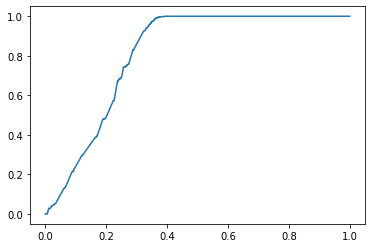

In [164]:

y_pred = attack_model_bundle.predict(np.concatenate((D_out[:, :-1], D_in[:, :-1])))
y_true = np.concatenate((D_out[:, -1], D_in[:, -1]))

fpr, tpr, _ = roc_curve(y_true, y_pred)

plt.plot(fpr, tpr)

print(f"AUC = {roc_auc_score(y_true, y_pred)}")

# Extras

## Check target model's behaviour in perturbed images

In [174]:
def study_perturbations(model, X, y, rs, ts):
  diffs = []
  y_pred = target_predict(model, X)    
  for c in range(10):
    #  given class acquire the changes in perturbed input instances given the model
    idx = y_pred[:, 0] == c
    X_c = X[idx]
    y_pred_c = y_pred[idx]
    perturbed_labels = (augmented_queries(model, X_c, y_pred_c, rs, ts) == y_pred_c).astype(np.int8)
    # Now we have to count how many labels diverge from the predicted label
    diff = len(perturbed_labels.reshape(-1)) - sum(perturbed_labels.reshape(-1)) # the labels are binary where 1 == y_pred = y_perturbed, otherwise 0
    diffs.append(int(100 * diff/len(perturbed_labels.reshape(-1)))) # append the percentage of changes in the class sample
    
  return diffs 

In [175]:
N_SAMPLES = 100
train_idx = np.random.choice(range(train_images.shape[0]), N_SAMPLES, replace=False)
test_idx = np.random.choice(range(attacker_images.shape[0]), N_SAMPLES, replace=False)

 Text(0, 0, '0%'),
 Text(0, 0, '10%'),
 Text(0, 0, '20%'),
 Text(0, 0, '30%'),
 Text(0, 0, '40%'),
 Text(0, 0, '50%'),
 Text(0, 0, '60%'),
 Text(0, 0, '70%'),
 Text(0, 0, '80%'),
 Text(0, 0, '90%'),
 Text(0, 0, '100%'),
 Text(0, 0, '0%'),
 Text(0, 0, '10%'),
 Text(0, 0, '20%'),
 Text(0, 0, '30%'),
 Text(0, 0, '40%'),
 Text(0, 0, '50%'),
 Text(0, 0, '60%'),
 Text(0, 0, '70%'),
 Text(0, 0, '80%'),
 Text(0, 0, '90%'),
 Text(0, 0, '100%'),
 Text(0, 0, '0%'),
 Text(0, 0, '10%'),
 Text(0, 0, '20%'),
 Text(0, 0, '30%'),
 Text(0, 0, '40%'),
 Text(0, 0, '50%'),
 Text(0, 0, '60%'),
 Text(0, 0, '70%'),
 Text(0, 0, '80%'),
 Text(0, 0, '90%'),
 Text(0, 0, '100%')]

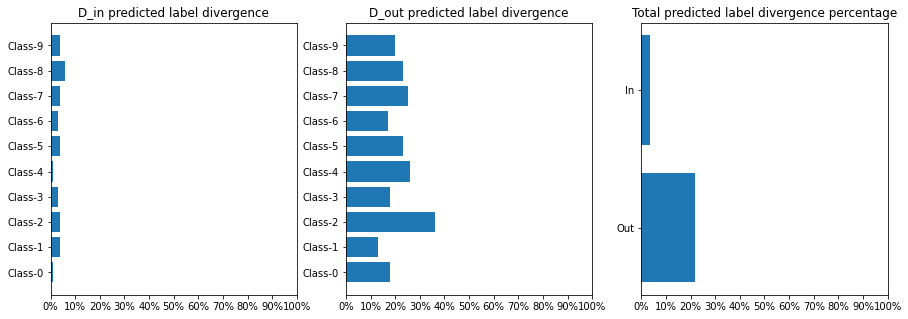

In [176]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# tests in D_in
diffs_per_class_D_in = study_perturbations(target_model, train_images[train_idx], train_labels[train_idx], r, d) 
total_diffs_in = sum(diffs_per_class_D_in)/10
axes[0].set_title('D_in predicted label divergence');
axes[0].barh(list(range(10)), diffs_per_class_D_in, tick_label=[f'Class-{i}' for i in range(10)])

# tests in D_out  
diffs_per_class_D_out= study_perturbations(target_model,attacker_images[test_idx],attacker_labels[test_idx], r, d)
total_diffs_out = sum(diffs_per_class_D_out)/10
axes[1].set_title('D_out predicted label divergence');
axes[1].barh(list(range(10)), diffs_per_class_D_out, tick_label=[f'Class-{i}' for i in range(10)])

axes[2].set_title('Total predicted label divergence percentage');
axes[2].barh([1, 0], [total_diffs_in, total_diffs_out], tick_label=['In', 'Out'])

plt.setp(axes, xticks=range(0, 101, 10), xticklabels=[f'{i}%' for i in range(0, 101, 10)])

## Attack a perturbation trained model

- We will apply augmentations to the dataset and re-train the target model.
- The attacker **does not** know our augmentation settings, so he will train with a normal dataset of zero augmentations
- We want to measure the quality of the attack when the target tries to defend MIAs by adding perturbed images of data samples 

In [177]:
# We will defend against the same rotations and translations that the attack models uses (worst case for the attacker)
rotates = create_rotates(r)
translates = create_translates(d)

X_train_aug = train_images
X_eval_aug = eval_images
y_train_aug = np.concatenate(tuple([train_labels] + [train_labels for rot in rotates] + [train_labels for tra in translates]))
y_eval_aug = np.concatenate(tuple([eval_labels] + [eval_labels for rot in rotates] + [eval_labels for tra in translates]))



for rot in rotates:
  aug_x = apply_augment(train_images, rot, 'r')
  X_train_aug = np.concatenate((X_train_aug,aug_x))
  aug_x = apply_augment(eval_images, rot, 'r')
  X_eval_aug = np.concatenate((X_eval_aug,aug_x))

for tra in translates:
  aug_x = apply_augment(train_images, tra, 'd')
  X_train_aug = np.concatenate((X_train_aug,aug_x))
  aug_x = apply_augment(eval_images, tra, 'd')
  X_eval_aug = np.concatenate((X_eval_aug ,aug_x))


In [178]:

with tf.device('/gpu:0'):
  X_train_aug = tf.convert_to_tensor(X_train_aug)
  y_train_aug = tf.convert_to_tensor(y_train_aug)
  X_eval_aug = tf.convert_to_tensor(X_eval_aug)
  y_eval_aug = tf.convert_to_tensor(y_eval_aug)
  target_model = f_target(X_train_aug, y_train_aug, X_eval_aug, y_eval_aug, epochs=10) 

Epoch 1/10
688/688 [==============================] - 10s 14ms/step - loss: 1.1850 - accuracy: 0.6403 - val_loss: 3.0155 - val_accuracy: 0.3853
Epoch 2/10
688/688 [==============================] - 9s 13ms/step - loss: 0.1942 - accuracy: 0.9388 - val_loss: 3.5806 - val_accuracy: 0.3740
Epoch 3/10
688/688 [==============================] - 9s 13ms/step - loss: 0.1092 - accuracy: 0.9673 - val_loss: 4.3989 - val_accuracy: 0.3804
Epoch 4/10
688/688 [==============================] - 9s 13ms/step - loss: 0.0985 - accuracy: 0.9710 - val_loss: 4.5038 - val_accuracy: 0.4078
Epoch 5/10
688/688 [==============================] - 8s 12ms/step - loss: 0.0822 - accuracy: 0.9762 - val_loss: 5.0450 - val_accuracy: 0.3900
Epoch 6/10
688/688 [==============================] - 9s 13ms/step - loss: 0.0758 - accuracy: 0.9785 - val_loss: 5.1546 - val_accuracy: 0.3704
Epoch 7/10
688/688 [==============================] - 8s 12ms/step - loss: 0.0684 - accuracy: 0.9805 - val_loss: 6.0791 - val_accuracy: 0.374

The model is quite overfitted so now all that is left is to evaluate the attack model we created before on the newly trained and "defended" target model with perturbations in the train dataset.

In [179]:
D_in = prepare_batch(target_model, train_images[:1000], train_labels[:1000], True)
print("Testing with 'in' data only:")
res_in = evaluate_attack(attack_model_bundle, D_in[:, :-1], D_in[:, -1], 10)

D_out = prepare_batch(target_model, attacker_images[:1000], attacker_labels[:1000], False)
print("\nTesting with 'out' data only:")
res_out = evaluate_attack(attack_model_bundle, D_out[:, :-1], D_out[:, -1], 10)

print("\nTesting with all prev data: ")
res_all = evaluate_attack(attack_model_bundle, np.concatenate((D_out[:, :-1], D_in[:, :-1])), np.concatenate((D_out[:, -1], D_in[:, -1])), 10)

print(f"\nTotal attack accuracy: {np.mean(res_all)}")

Testing with 'in' data only:
class-1: 0.978723406791687
class-2: 0.9807692170143127
class-3: 0.9797979593276978
class-4: 0.969072163105011
class-5: 1.0
class-6: 0.9894737005233765
class-7: 0.9677419066429138
class-8: 0.9900000095367432
class-9: 0.8585858345031738
class-10: 1.0

Testing with 'out' data only:
class-1: 0.6842105388641357
class-2: 0.488095223903656
class-3: 0.7804877758026123
class-4: 0.8064516186714172
class-5: 0.5416666865348816
class-6: 0.6486486196517944
class-7: 0.5961538553237915
class-8: 0.6136363744735718
class-9: 0.7452830076217651
class-10: 0.7799999713897705

Testing with all prev data: 
class-1: 0.8306878209114075
class-2: 0.7606382966041565
class-3: 0.869369387626648
class-4: 0.8894736766815186
class-5: 0.7962962985038757
class-6: 0.8058252334594727
class-7: 0.7715736031532288
class-8: 0.813829779624939
class-9: 0.800000011920929
class-10: 0.8894472122192383

Total attack accuracy: 0.8227141320705413


### Conclusion

To conclude if the model is more vulnerable, we must check what are the label divergence percentage in the newly trained model.

 Text(0, 0, '0%'),
 Text(0, 0, '10%'),
 Text(0, 0, '20%'),
 Text(0, 0, '30%'),
 Text(0, 0, '40%'),
 Text(0, 0, '50%'),
 Text(0, 0, '60%'),
 Text(0, 0, '70%'),
 Text(0, 0, '80%'),
 Text(0, 0, '90%'),
 Text(0, 0, '100%'),
 Text(0, 0, '0%'),
 Text(0, 0, '10%'),
 Text(0, 0, '20%'),
 Text(0, 0, '30%'),
 Text(0, 0, '40%'),
 Text(0, 0, '50%'),
 Text(0, 0, '60%'),
 Text(0, 0, '70%'),
 Text(0, 0, '80%'),
 Text(0, 0, '90%'),
 Text(0, 0, '100%'),
 Text(0, 0, '0%'),
 Text(0, 0, '10%'),
 Text(0, 0, '20%'),
 Text(0, 0, '30%'),
 Text(0, 0, '40%'),
 Text(0, 0, '50%'),
 Text(0, 0, '60%'),
 Text(0, 0, '70%'),
 Text(0, 0, '80%'),
 Text(0, 0, '90%'),
 Text(0, 0, '100%')]

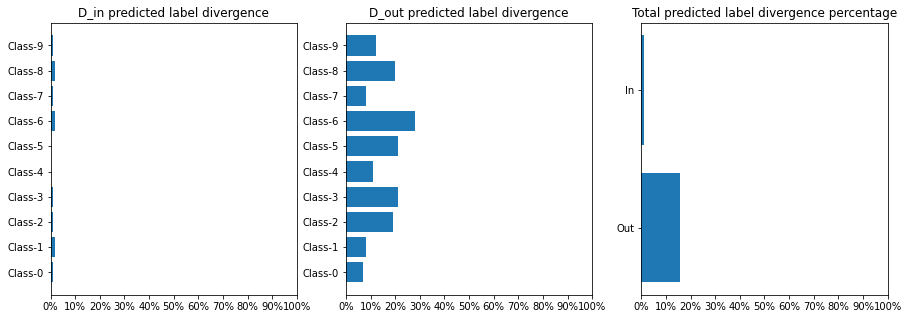

In [181]:
# test it onthe same data as we tested the non-adjusted to augmentation model
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# tests in D_in
diffs_per_class_D_in = study_perturbations(target_model, train_images[train_idx], train_labels[train_idx], r, d) 
total_diffs_in = sum(diffs_per_class_D_in)/10
axes[0].set_title('D_in predicted label divergence');
axes[0].barh(list(range(10)), diffs_per_class_D_in, tick_label=[f'Class-{i}' for i in range(10)])

# tests in D_out  
diffs_per_class_D_out= study_perturbations(target_model,attacker_images[test_idx],attacker_labels[test_idx], r, d)
total_diffs_out = sum(diffs_per_class_D_out)/10
axes[1].set_title('D_out predicted label divergence');
axes[1].barh(list(range(10)), diffs_per_class_D_out, tick_label=[f'Class-{i}' for i in range(10)])

axes[2].set_title('Total predicted label divergence percentage');
axes[2].barh([1, 0], [total_diffs_in, total_diffs_out], tick_label=['In', 'Out'])

plt.setp(axes, xticks=range(0, 101, 10), xticklabels=[f'{i}%' for i in range(0, 101, 10)])

We can see that the general percentage of predicted label divergence has fallen, **but** the confidence of the ML algorithm in predicting the label of perturbed instances of instances in $D_{in}$ is even higher that before. This means that the adjusted model is even more vulnerable. Next step is to run all that with a well-generalized model and tune the attack model to get max accuracy.